In [13]:
import PIL.Image as Image
import imageio
import pylab as py
%matplotlib inline
import numpy as np
import csv
import warnings
import time
from numpy.linalg import eig, inv

In [2]:
csv_file = '470_30.csv'
#threshold = 40
input_frame = '470_30/frame%04d.jpg'
output_frame = '470_30_circle/frame%04d.jpg'
test_frame = '470_30/frame0001.jpg'
first_frame = '470_30/frame0001.jpg'
n_frame = 4547
estimate_center = np.array([500,500])
estimate_radius = 300

In [3]:
def createLineIterator(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])   
        
    Source code: https://stackoverflow.com/questions/32328179/opencv-3-0-python-lineiterator
    """
    #define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
    itbuffer.fill(np.nan)

    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: #vertical line segment
        itbuffer[:,0] = P1X
        if negY:
            itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
        else:
            itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
    elif P1Y == P2Y: #horizontal line segment
        itbuffer[:,1] = P1Y
        if negX:
            itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
        else:
            itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else: #diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = dX.astype(np.float32)/dY.astype(np.float32)
            if negY:
                itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
            else:
                itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
            itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(int) + P1X
        else:
            slope = dY.astype(np.float32)/dX.astype(np.float32)
            if negX:
                itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
            else:
                itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
            itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(int) + P1Y

    #Remove points outside of image
    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

    #Get intensities from img ndarray
    itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

    return itbuffer

In [4]:
'''Idea from: https://stackoverflow.com/questions/45922566/ellipse-fitting-for-pupil-center'''

def find_edge_points(center, radius, img, d_theta = np.pi/180 ):
#    r = 2 * radius
    r = 500
    points = []
    
    for theta in np.arange(0, 2*np.pi, d_theta):
        end_point_x = (center[0] + r*np.cos(theta)).astype(int)
        end_point_y = (center[1] + r*np.sin(theta)).astype(int)
        end_point = np.array([end_point_x,end_point_y])
        result = createLineIterator(center, end_point, img)

        '''need to twiddle more to find a better way to find the edge points'''
#        diff = []
#        sum_lum = []
#        for i in range(1,len(result)):
#            diff.append(result[i][2] - result[i-1][2])
#        for i in range(len(diff)):    
#            sum_lum.append(sum(diff[:i]))
        #print(sum_lum)
#        for i in range(2,len(sum_lum)):
#            if sum_lum[i] > 3 * sum_lum[i-1] and sum_lum[i-1] > 3 * sum_lum[i-2] and sum_lum[i-1] > 0:
#                points.append((result[i][0],result[i][1]))
#                break

        edge_detected = False
        for i in range(1,len(result)-3):
            
            if result[i-1][2] == 255:
                edge_detected = True
                for j in range(3):
                    if result[i+j][2] == 0:
                        edge_detected = False
            if edge_detected:
                points.append((result[i][0],result[i][1]))
                break
    return points

'''http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html'''

def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


def ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5*np.arctan(2*b/(a-c))

def ellipse_angle_of_rotation2( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2

def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

In [5]:
def image_thresholding(img,threshold):
    threshold_pupil = threshold  
    idx1 = img[:,:] > threshold_pupil 
    idx2 = img[:,:] < threshold_pupil
    img[idx1] = 255
    img[idx2] = 0
    return img
    
def get_image_mat(filename):
    img = Image.open(filename).convert('LA')
    #img = img.resize((120, 100), Image.ANTIALIAS)
    img = np.asarray(img, 'double').transpose()  
    img = img[0,:,:] # just one layer
    return img

def get_binary_image_mat(filename,threshold):
    img = Image.open(filename).convert('LA')
    #img = img.resize((120, 100), Image.ANTIALIAS)
    img = np.asarray(img, 'double').transpose()  
    img = img[0,:,:] # just one layer
    img = image_thresholding(img,threshold)
    return img

def show_image(img):
    py.imshow(img.transpose(), cmap=py.cm.Greys_r)
    
def add_circle(img_mat,center,radius,luminance=255):
    for rad in np.arange(0,2*np.pi, 0.01):
        for width in [-0.5, 0, 0.5]: # give width to the circle for viewing
            x = int(center[0] + (radius+width) * np.cos(rad))
            y = int(center[1] + (radius+width) * np.sin(rad))
            img_mat.transpose()[x,y] = luminance
    return


def add_ellipse(img_mat,center,a,b,phi,luminance=255):
    c = np.sqrt(a*a-b*b)
    e = c/a
    for rad in np.arange(0,2*np.pi, 0.01):
        for width in [-1, -0.5, 0, 0.5, 1]: # give width to the circle for viewing
            #r = a*(1-e*e)/(1+e*np.cos(rad))
            #x = int(center[0] + c + r * np.cos(rad))
            #y = int(center[1] + r * np.sin(rad))
            x = int(center[0] + (a+width)*np.cos(rad)*np.cos(phi) - (b+width)*np.sin(rad)*np.sin(phi))
            y = int(center[1] + (a+width)*np.cos(rad)*np.sin(phi) + (b+width)*np.sin(rad)*np.cos(phi))
            img_mat.transpose()[x,y] = luminance
    return

def save_image(img, center, radius, a, b, phi, file_name, lum = 255):
    show_circle_img = img.copy()
    add_circle(show_circle_img,center,radius,lum)
    #add_ellipse(show_circle_img,center,a,b,phi,lum)
    imageio.imwrite(file_name, show_circle_img.transpose())
    return

def export_to_csv(radius_data):
    with open (csv_file, 'w') as csvfile:
        writer = csv.writer(csvfile, lineterminator = '\n', delimiter=' ')
        for num in radius_data:
            writer.writerow([num])
    return

def isNaN(num):
    return num != num

53.8198860168457


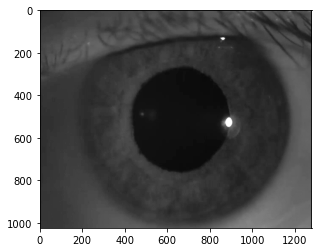

In [6]:
#testing on one image
img = get_image_mat(test_frame)
show_image(img)
print(img.mean(axis=0).mean())

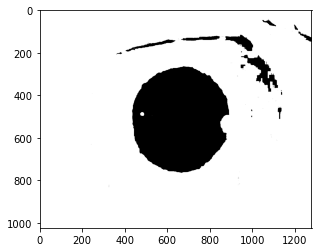

In [7]:
threshold = img.mean(axis=0).mean()*0.7
img = get_binary_image_mat(test_frame,threshold)
show_image(img)

513.7302022583175
center =  [513.73020226 658.798734  ]
angle of rotation =  -0.13900064812458288
axes =  [251.06282084 225.07631468]
area =  177526.0427686862
radius =  237.7147333851212


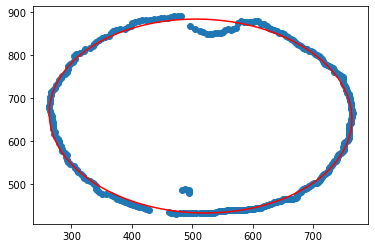

In [8]:
test_estimate_center = np.array([600,600])
test_estimate_radius = 230

test_estimate_a = test_estimate_radius
test_estimate_b = test_estimate_radius

points = find_edge_points(test_estimate_center,test_estimate_radius,img)
#print(points)
a_points = np.array(points)
x = a_points[:, 0]
y = a_points[:, 1]
py.scatter(x,y)

eye = fitEllipse(x,y)
center = ellipse_center(eye)

if isinstance(center[0], complex):
    center = test_estimate_center
    r = test_estimate_radius
    a = test_estimate_a
    b = test_estimate_b        
else:
    phi = ellipse_angle_of_rotation2(eye)
    axes = ellipse_axis_length(eye)
    a, b = axes
    area = np.pi*a*b
    r = np.sqrt(a*b)



print(center[0])
print ("center = ",  center)
print ("angle of rotation = ",  phi)
print ("axes = ", axes)
print ("area = ", area)
print ("radius = ", r)

R = np.arange(0,2*np.pi, 0.01)
xx = center[0] + a*np.cos(R)*np.cos(phi) - b*np.sin(R)*np.sin(phi)
yy = center[1] + a*np.cos(R)*np.sin(phi) + b*np.sin(R)*np.cos(phi)
py.plot(xx,yy, color = 'red')

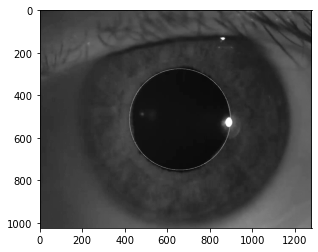

In [9]:
show_circle_img = get_image_mat(test_frame)
add_circle(show_circle_img,center,r,255)
#add_ellipse(show_circle_img,center,a,b,255)
show_image(show_circle_img)

In [19]:
radius_data = []


estimate_a = estimate_radius
estimate_b = estimate_radius
estimate_threshold = get_image_mat(first_frame).mean(axis=0).mean()*0.7

# Log the time
time_start = time.time()

for i in range(1,n_frame+1):
    original_img = get_image_mat(input_frame %i)
    threshold = original_img.mean(axis=0).mean()
    if threshold < 50:
        threshold *= 0.6
    else:
        threshold *= 0.7
    
#    print(threshold)
    
    img = get_binary_image_mat(input_frame %i,threshold)
    
    points = find_edge_points(estimate_center,estimate_radius,img)
    a_points = np.array(points)
    x = a_points[:, 0]
    y = a_points[:, 1]
    eye = fitEllipse(x,y)
    center = ellipse_center(eye)
    if isinstance(center[0], complex):
        center = estimate_center
        r = estimate_radius
        a = estimate_a
        b = estimate_b        
    else:
        phi = ellipse_angle_of_rotation2(eye)
        axes = ellipse_axis_length(eye)
        a, b = axes
        area = np.pi*a*b
        r = np.sqrt(a*b)
    
#        print("center = ",  center)
#    print("angle of rotation = ",  phi)
#    print("axes = ", axes)
#    print ("area = ", area)
#    print ("radius = ", r)
    
        if isNaN(r) or isinstance(r, complex) or r<100 or (abs(center[0]-estimate_center[0])>5 and (threshold-estimate_threshold)>3):
            center = estimate_center
            r = estimate_radius
            a = estimate_a
            b = estimate_b
            threshold = estimate_threshold
        else:
            estimate_center = center.astype(int)
            estimate_radius = r.astype(int)
            estimate_a = a.astype(int)
            estimate_b = b.astype(int)
            estimate_threshold = threshold
    
    radius_data.append(r)
    print("Frame: ",i, " ,Radius:", r)
#    print(original_img)
#    with warnings.catch_warnings():
#        warnings.simplefilter("ignore")
#        save_image(original_img,center,r,a,b,phi,output_frame %i) 
    save_image(original_img.astype(np.uint8),center,r,a,b,phi,output_frame %i)
        
export_to_csv(radius_data)
time_end = time.time() 
print ("It took %d seconds forconversion." % (time_end-time_start))

It took 949 seconds forconversion.
